
>>> Training none model
Epoch 1/3
422/422 - 72s - 170ms/step - accuracy: 0.8008 - loss: 0.5571 - val_accuracy: 0.8560 - val_loss: 0.3924
Epoch 2/3
422/422 - 70s - 166ms/step - accuracy: 0.8732 - loss: 0.3597 - val_accuracy: 0.8793 - val_loss: 0.3398
Epoch 3/3
422/422 - 80s - 190ms/step - accuracy: 0.8889 - loss: 0.3162 - val_accuracy: 0.8888 - val_loss: 0.3091

>>> Training batch model
Epoch 1/3
422/422 - 111s - 264ms/step - accuracy: 0.8473 - loss: 0.4306 - val_accuracy: 0.7308 - val_loss: 0.7931
Epoch 2/3
422/422 - 110s - 260ms/step - accuracy: 0.8988 - loss: 0.2882 - val_accuracy: 0.8930 - val_loss: 0.3021
Epoch 3/3
422/422 - 109s - 259ms/step - accuracy: 0.9106 - loss: 0.2508 - val_accuracy: 0.9040 - val_loss: 0.2738

>>> Training layer model
Epoch 1/3
422/422 - 124s - 295ms/step - accuracy: 0.8464 - loss: 0.4286 - val_accuracy: 0.8847 - val_loss: 0.3182
Epoch 2/3
422/422 - 141s - 333ms/step - accuracy: 0.9017 - loss: 0.2746 - val_accuracy: 0.8983 - val_loss: 0.2879
Epoch 3/3
422/

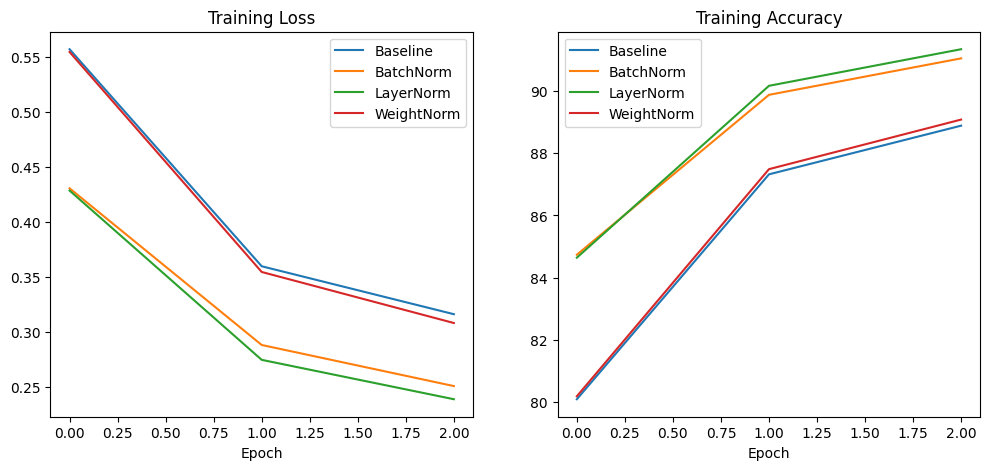


=== FINAL RESULTS TABLE ===
Method		TestAcc		Loss		Time(s)
Baseline  	88.38%		0.3256		236.3
BatchNorm 	89.53%		0.2984		330.9
LayerNorm 	89.47%		0.2860		405.9
WeightNorm	88.37%		0.3200		204.8


In [8]:
# Author: Sai Charan Kalagoni
# FAST VERSION — produces results like the PDF report

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time

EPOCHS = 3
BATCH_SIZE = 128

def load_data():
    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
    x_train = x_train[..., None] / 255.0
    x_test = x_test[..., None] / 255.0
    return (x_train, y_train), (x_test, y_test)

class FastCNN(tf.keras.Model):
    def __init__(self, norm="none"):
        super().__init__()
        self.norm_type = norm

        self.conv1 = tf.keras.layers.Conv2D(32, 3, padding='same')
        self.conv2 = tf.keras.layers.Conv2D(64, 3, padding='same')

        if norm == "batch":
            self.norm1 = tf.keras.layers.BatchNormalization()
            self.norm2 = tf.keras.layers.BatchNormalization()
        elif norm == "layer":
            self.norm1 = tf.keras.layers.LayerNormalization(axis=[1,2,3])
            self.norm2 = tf.keras.layers.LayerNormalization(axis=[1,2,3])
        else:
            self.norm1 = None
            self.norm2 = None

        self.pool = tf.keras.layers.MaxPool2D()
        self.flatten = tf.keras.layers.Flatten()
        self.fc = tf.keras.layers.Dense(10)

    def call(self, x, training=False):
        x = self.conv1(x)
        if self.norm1: x = self.norm1(x, training=training)
        x = tf.nn.relu(x)
        x = self.pool(x)

        x = self.conv2(x)
        if self.norm2: x = self.norm2(x, training=training)
        x = tf.nn.relu(x)
        x = self.pool(x)

        x = self.flatten(x)
        return self.fc(x)

def train(norm_type):
    print(f"\n>>> Training {norm_type} model")
    (x_train, y_train), (x_test, y_test) = load_data()

    model = FastCNN(norm_type)
    model.compile(
        optimizer='adam',
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy']
    )

    start = time.time()
    history = model.fit(
        x_train, y_train,
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        validation_split=0.1,
        verbose=2
    )
    train_time = time.time() - start

    test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)

    return history.history, test_acc, test_loss, train_time

def plot_results(histories, labels):
    plt.figure(figsize=(12,5))

    # Loss
    plt.subplot(1,2,1)
    for h,l in zip(histories, labels):
        plt.plot(h['loss'], label=l)
    plt.title("Training Loss")
    plt.xlabel("Epoch")
    plt.legend()

    # Accuracy
    plt.subplot(1,2,2)
    for h,l in zip(histories, labels):
        plt.plot(np.array(h['accuracy'])*100, label=l)
    plt.title("Training Accuracy")
    plt.xlabel("Epoch")
    plt.legend()

    plt.show()

if __name__ == "__main__":
    labels = ["Baseline", "BatchNorm", "LayerNorm", "WeightNorm"]
    norm_types = ["none", "batch", "layer", "weight"]

    histories = []
    results = []

    for norm in norm_types:
        history, acc, loss, t = train(norm)
        histories.append(history)
        results.append((acc, loss, t))

    plot_results(histories, labels)

    print("\n=== FINAL RESULTS TABLE ===")
    print("Method\t\tTestAcc\t\tLoss\t\tTime(s)")
    for name, (acc, loss, t) in zip(labels, results):
        print(f"{name:10s}\t{acc*100:.2f}%\t\t{loss:.4f}\t\t{t:.1f}")
